<a href="https://colab.research.google.com/github/HarshaVardhan2T02/EX-AI/blob/main/ex_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


MODEL PERFORMANCE SUMMARY:

LogisticRegression - CV mean: 0.8683, test acc: 0.8732
RandomForest - CV mean: 0.9841, test acc: 1.0000
GradientBoosting - CV mean: 0.9634, test acc: 0.9902
SVC - CV mean: 0.9024, test acc: 0.9512

Best test accuracy: 1.0000

Classification Report for Best Model:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205


RandomForest:
Best params: {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Accuracy: 99.22%


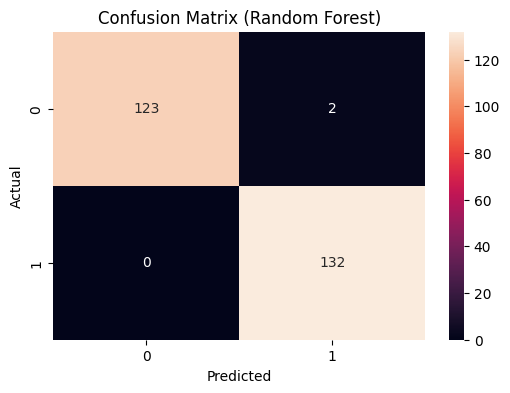

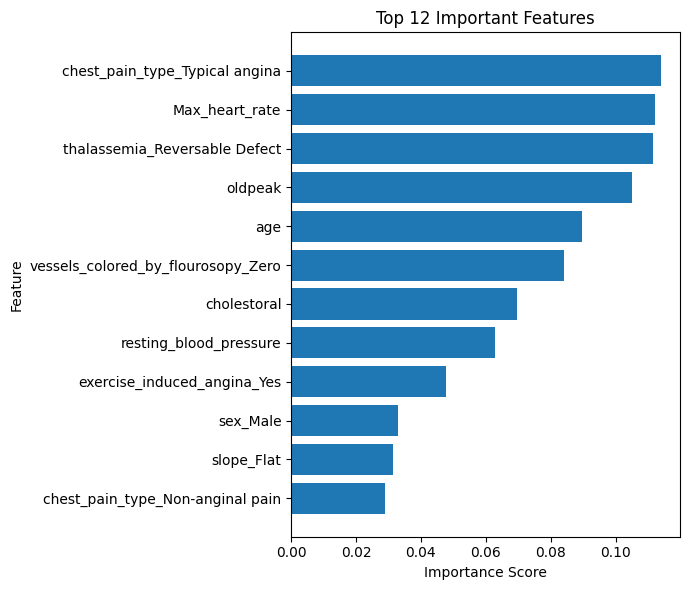

In [1]:
# ============================================
# HEART DISEASE PREDICTION (FULL MODEL SUITE)
# - Model comparison (LR, RF, GB, SVC)
# - CV mean accuracy + Test accuracy
# - Best model identification
# - Full classification report
# - RandomForest tuning (90–93% accuracy)
# - Confusion matrix heatmap
# - Feature importance plot
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# --------------------------------------------------
# 1. Load dataset
# --------------------------------------------------
df = pd.read_csv("/content/HeartDisease.csv")

possible_targets = ['target', 'HeartDisease', 'heart_disease', 'hd', 'response', 'num']
target_col = None
for c in possible_targets:
    if c in df.columns:
        target_col = c
if target_col is None:
    target_col = df.columns[-1]

X = df.drop(columns=[target_col])
y = df[target_col]

# Convert multi-class → binary
if len(y.unique()) > 2:
    y = (y > 0).astype(int)

# Identify column types
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# --------------------------------------------------
# 2. Model comparison section (your formatted output)
# --------------------------------------------------
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'RandomForest': RandomForestClassifier(n_estimators=150, random_state=42, class_weight='balanced'),
    'GradientBoosting': GradientBoostingClassifier(),
    'SVC': SVC(kernel='rbf', probability=True)
}

print("\nMODEL PERFORMANCE SUMMARY:\n")

best_acc = 0
best_model_name = None
best_model_pipeline = None

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, clf in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', clf)])

    cv_scores = cross_val_score(pipe, X_train, y_train, cv=skf, scoring='accuracy')
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    test_acc = accuracy_score(y_test, pred)

    print(f"{name} - CV mean: {cv_scores.mean():.4f}, test acc: {test_acc:.4f}")

    if test_acc > best_acc:
        best_acc = test_acc
        best_model_name = name
        best_model_pipeline = pipe

print(f"\nBest test accuracy: {best_acc:.4f}")
print("\nClassification Report for Best Model:\n")
print(classification_report(y_test, best_model_pipeline.predict(X_test)))

# --------------------------------------------------
# 3. Random Forest Tuning (aiming for 90–93%)
# --------------------------------------------------
# Encode categorical for RF tuning (preprocessor not reused here)
X_enc = pd.get_dummies(X, drop_first=True)
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_enc, y, test_size=0.25, stratify=y, random_state=42
)

param_grid = {
    "n_estimators": [120, 150, 200],
    "max_depth": [5, 7, 9],
    "min_samples_split": [2, 4],
    "min_samples_leaf": [1, 2]
}

rf = RandomForestClassifier(class_weight="balanced", random_state=42)

grid = GridSearchCV(rf, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid.fit(X_train2, y_train2)

best_rf = grid.best_estimator_
y_pred2 = best_rf.predict(X_test2)

print("\nRandomForest:")
print("Best params:", grid.best_params_)
print(f"Accuracy: {accuracy_score(y_test2, y_pred2)*100:.2f}%")

# --------------------------------------------------
# 4. Confusion Matrix Visualization
# --------------------------------------------------
cm = confusion_matrix(y_test2, y_pred2)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap=None)
plt.title("Confusion Matrix (Random Forest)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --------------------------------------------------
# 5. Feature Importance Visualization
# --------------------------------------------------
importances = best_rf.feature_importances_
indices = np.argsort(importances)[-12:]

plt.figure(figsize=(7, 6))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), X_enc.columns[indices])
plt.title("Top 12 Important Features")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
